In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from boruta import BorutaPy
import optuna
import math
import collections
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.special import boxcox1p
from statistics import mean, variance
from tqdm import tqdm
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.neighbors.kde import KernelDensity

In [3]:
from xgboost import XGBRegressor

# Data

## Load

In [564]:
data_train = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/train.csv')
x_test = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/test.csv')
pd.set_option('display.max_columns', 90)

In [5]:
print(data_train.shape)
data_train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print(x_test.shape)
x_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Analyse

### About Target

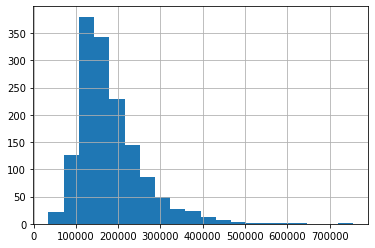

In [7]:
prices = data_train.SalePrice.hist(bins=20)

This histogram seems Distorted distribution to the right. So, It may be Lognormal distribution.

### About Features

In [8]:
types = data_train.dtypes
print(types.unique())
print(collections.Counter(data_train.dtypes))
types

[dtype('int64') dtype('O') dtype('float64')]
Counter({dtype('O'): 43, dtype('int64'): 35, dtype('float64'): 3})


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [550]:
def col_num(df):
    numerics = []
    for col in df.columns:
        if df[col].dtype!='object':
            if col in ('Id', 'SalePrice'):
                pass
            else:
                numerics.append(col)
    return numerics

In [9]:
def count_byChi2(_data, significance):
    data = _data.fillna(_data.median())
    data = data.reset_index(drop=True)
    mean = data.mean()
    variance = data.var()
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - mean)**2 / variance
        anomaly_scores.append(anomaly_score)
    threshold = stats.chi2.interval(1-significance, 1)[1]
    outliers = []
    for i, an in enumerate(anomaly_scores):
        if an > threshold:
            outliers.append(i)
    return outliers

In [10]:
def desc(columns, df, significance=0.001):    
    colorlist = ["r", "g", "b", "c", "m", "y"]
    for i, col in enumerate(columns):       
        outliers = count_byChi2(df[col],significance)
        
        df[col].plot(figsize=(7,1.5), color=colorlist[i%len(colorlist)])
        if len(outliers) is not 0:
            out_min = pd.Series(np.zeros(df[col].shape))
            out_min[:] = min(df.reset_index(drop=True)[col][outliers])
            out_min.plot(figsize=(7,1.5), color='black')
        plt.show()
        
        plt.figure(figsize=(7,1.5))
        sns.distplot(df[col].dropna(), hist=True, rug=True,
                             color=colorlist[i%len(colorlist)])
        plt.show()
        
        sns.boxplot(data=df[col].dropna())
        plt.show()
        
        print ('{} has {} NaNs.'.format(col, df[col].isnull().sum()))
        print('Skewness : ', df[col].skew())
        print('Kurtosis : ', df[col].kurt())
        print('Number of anomaly scores over threshold({}%) : {} / {}'
                  .format(significance*100, len(outliers),
                                len(df[col])))
        if len(outliers) is not 0:
            print('Border line : ', out_min[0])
        else:
            pass
        plt.close()
        print('-'*100)

In [598]:
def skews(df, col_num=col_num):
    _df = df[col_num].fillna(df.mean())
    skewness = _df.apply(lambda x: stats.skew(x))
    return skewness.sort_values(ascending=False)

In [599]:
skews(data_train)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -0.667488
dtype: float64

In [575]:
skews(data_train)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -0.667488
dtype: float64

#### Numeric Int

In [11]:
numerics_int = [col for col in types.drop(['Id','SalePrice']).index 
                            if types[col]=='int64']
print('numeric_int is ...')
print(numerics_int)

numeric_int is ...
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


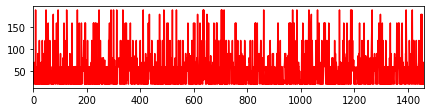

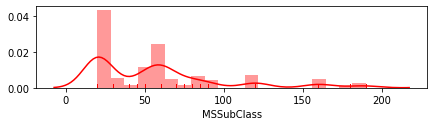

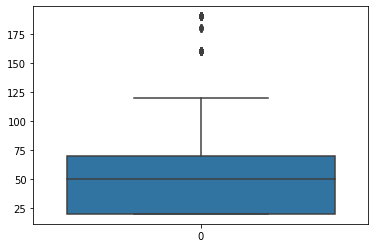

MSSubClass has 0 NaNs.
Skewness :  1.4076567471495591
Kurtosis :  1.5801879649863309
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


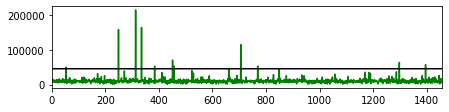

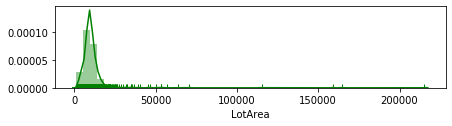

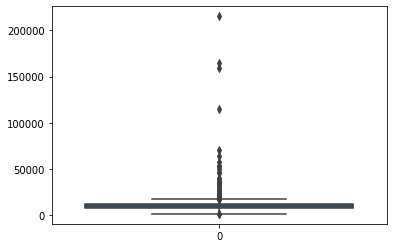

LotArea has 0 NaNs.
Skewness :  12.207687851233496
Kurtosis :  203.24327101886033
Number of anomaly scores over threshold(0.1%) : 13 / 1460
Border line :  45600.0
----------------------------------------------------------------------------------------------------


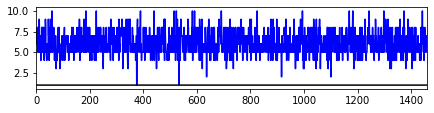

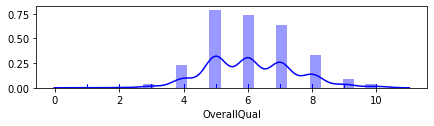

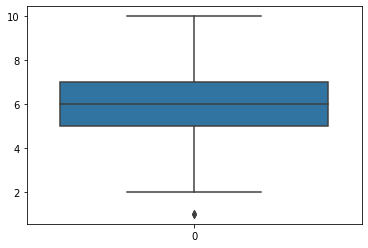

OverallQual has 0 NaNs.
Skewness :  0.2169439277628693
Kurtosis :  0.09629277835615113
Number of anomaly scores over threshold(0.1%) : 2 / 1460
Border line :  1.0
----------------------------------------------------------------------------------------------------


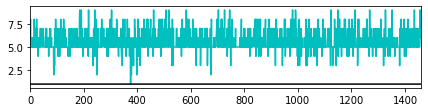

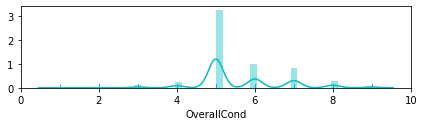

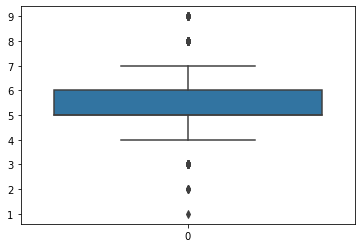

OverallCond has 0 NaNs.
Skewness :  0.6930674724842182
Kurtosis :  1.1064134613731684
Number of anomaly scores over threshold(0.1%) : 1 / 1460
Border line :  1.0
----------------------------------------------------------------------------------------------------


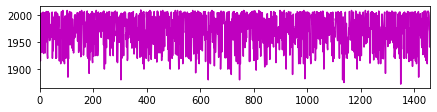

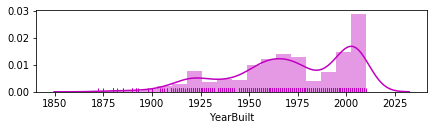

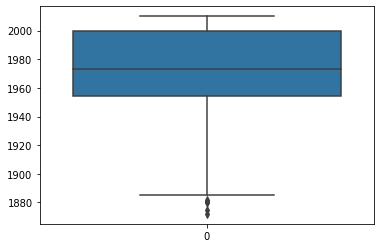

YearBuilt has 0 NaNs.
Skewness :  -0.613461172488183
Kurtosis :  -0.43955194159361977
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


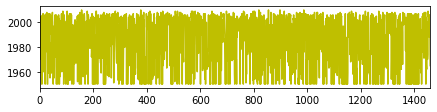

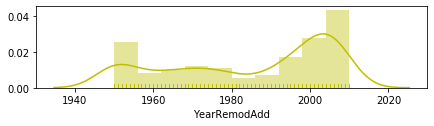

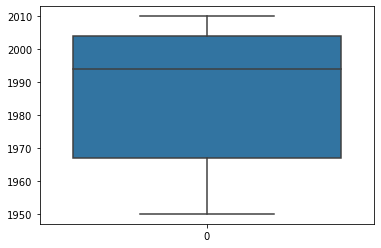

YearRemodAdd has 0 NaNs.
Skewness :  -0.5035620027004709
Kurtosis :  -1.2722451924732956
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


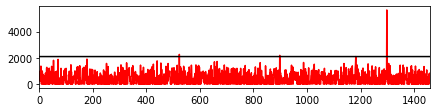

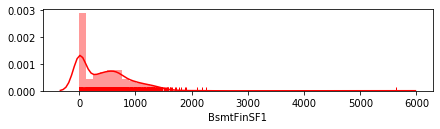

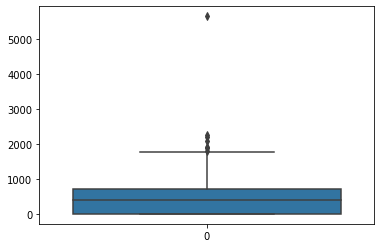

BsmtFinSF1 has 0 NaNs.
Skewness :  1.685503071910789
Kurtosis :  11.118236291964712
Number of anomaly scores over threshold(0.1%) : 4 / 1460
Border line :  2096.0
----------------------------------------------------------------------------------------------------


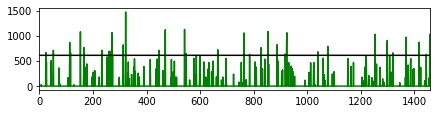

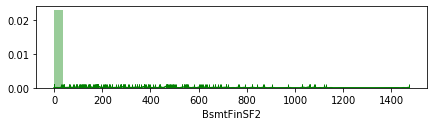

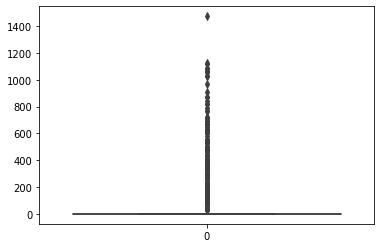

BsmtFinSF2 has 0 NaNs.
Skewness :  4.255261108933303
Kurtosis :  20.11333754558646
Number of anomaly scores over threshold(0.1%) : 36 / 1460
Border line :  612.0
----------------------------------------------------------------------------------------------------


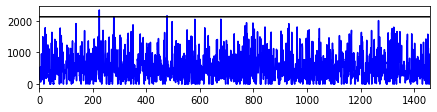

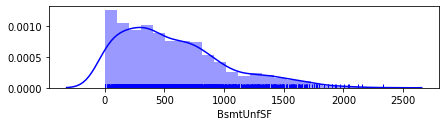

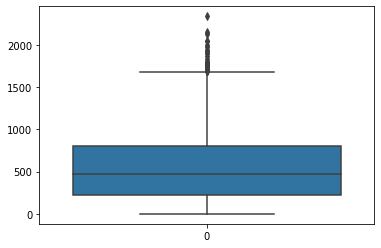

BsmtUnfSF has 0 NaNs.
Skewness :  0.9202684528039037
Kurtosis :  0.47499398780908475
Number of anomaly scores over threshold(0.1%) : 3 / 1460
Border line :  2121.0
----------------------------------------------------------------------------------------------------


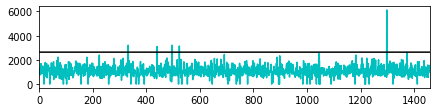

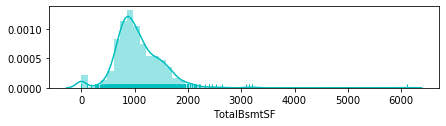

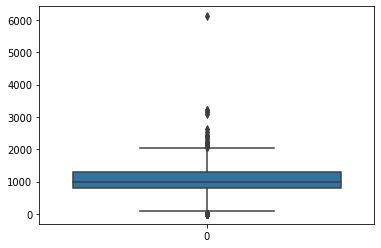

TotalBsmtSF has 0 NaNs.
Skewness :  1.5242545490627664
Kurtosis :  13.250483281984796
Number of anomaly scores over threshold(0.1%) : 6 / 1460
Border line :  2633.0
----------------------------------------------------------------------------------------------------


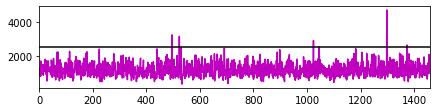

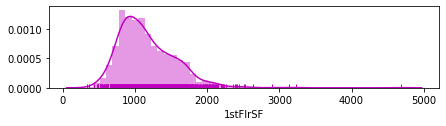

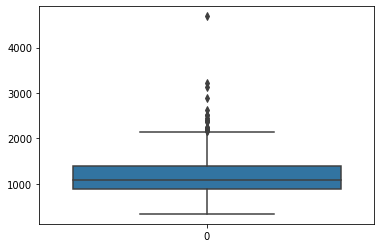

1stFlrSF has 0 NaNs.
Skewness :  1.3767566220336365
Kurtosis :  5.74584148244079
Number of anomaly scores over threshold(0.1%) : 7 / 1460
Border line :  2515.0
----------------------------------------------------------------------------------------------------


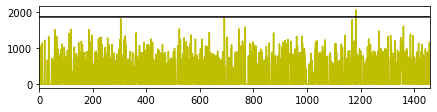

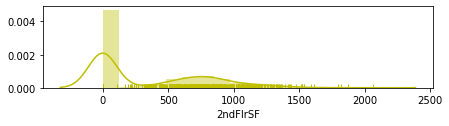

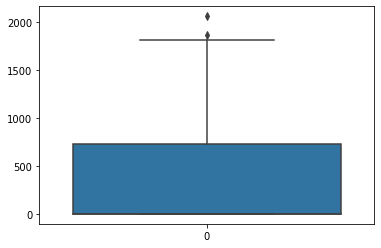

2ndFlrSF has 0 NaNs.
Skewness :  0.8130298163023265
Kurtosis :  -0.5534635576075795
Number of anomaly scores over threshold(0.1%) : 2 / 1460
Border line :  1872.0
----------------------------------------------------------------------------------------------------


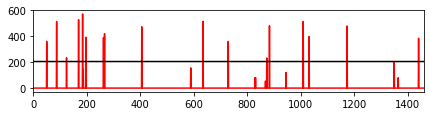

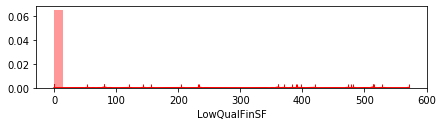

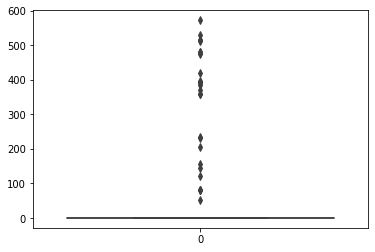

LowQualFinSF has 0 NaNs.
Skewness :  9.011341288465387
Kurtosis :  83.2348166744174
Number of anomaly scores over threshold(0.1%) : 19 / 1460
Border line :  205.0
----------------------------------------------------------------------------------------------------


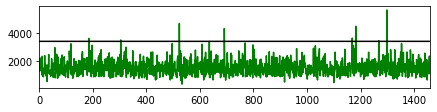

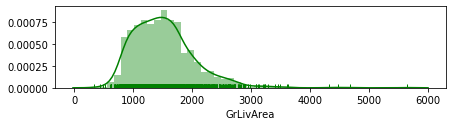

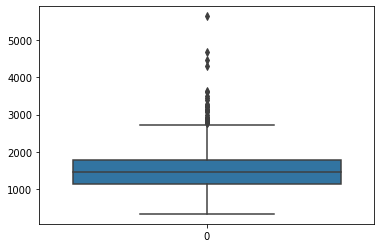

GrLivArea has 0 NaNs.
Skewness :  1.3665603560164552
Kurtosis :  4.895120580693174
Number of anomaly scores over threshold(0.1%) : 9 / 1460
Border line :  3395.0
----------------------------------------------------------------------------------------------------


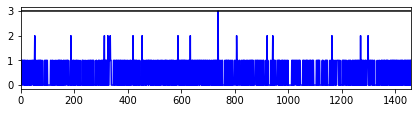

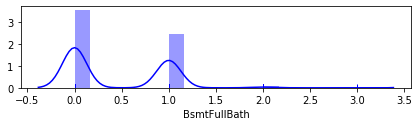

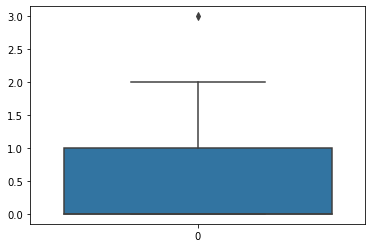

BsmtFullBath has 0 NaNs.
Skewness :  0.596066609663168
Kurtosis :  -0.8390982654634271
Number of anomaly scores over threshold(0.1%) : 1 / 1460
Border line :  3.0
----------------------------------------------------------------------------------------------------


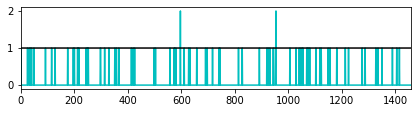

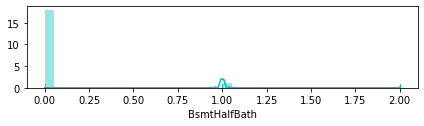

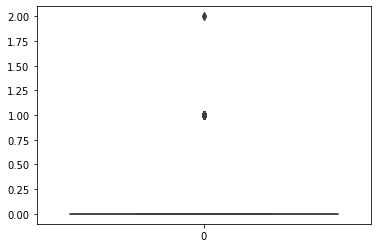

BsmtHalfBath has 0 NaNs.
Skewness :  4.103402697955168
Kurtosis :  16.396641945350446
Number of anomaly scores over threshold(0.1%) : 82 / 1460
Border line :  1.0
----------------------------------------------------------------------------------------------------


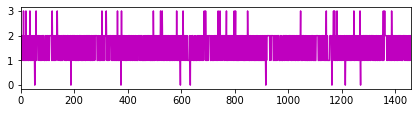

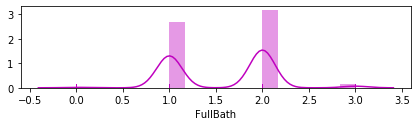

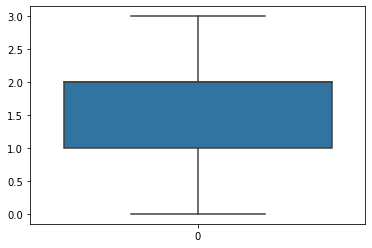

FullBath has 0 NaNs.
Skewness :  0.036561558402727165
Kurtosis :  -0.8570428212743262
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


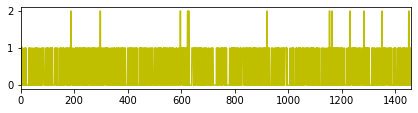

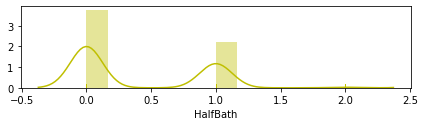

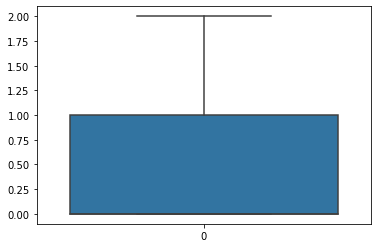

HalfBath has 0 NaNs.
Skewness :  0.675897448233722
Kurtosis :  -1.0769272841476227
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


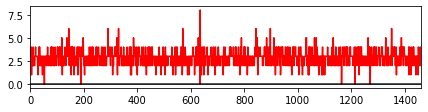

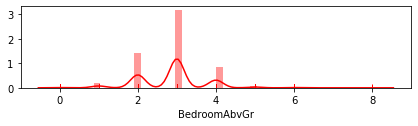

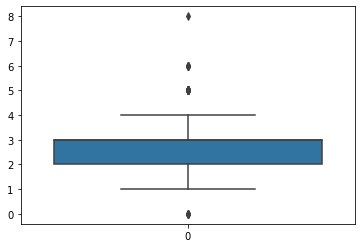

BedroomAbvGr has 0 NaNs.
Skewness :  0.21179009627507137
Kurtosis :  2.230874582191236
Number of anomaly scores over threshold(0.1%) : 14 / 1460
Border line :  0.0
----------------------------------------------------------------------------------------------------


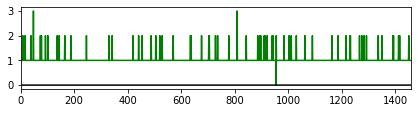

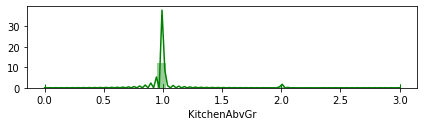

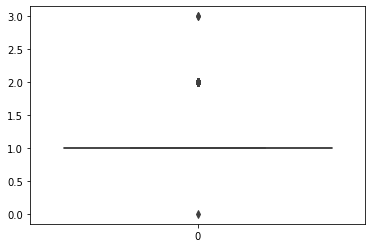

KitchenAbvGr has 0 NaNs.
Skewness :  4.488396777072859
Kurtosis :  21.532403840138784
Number of anomaly scores over threshold(0.1%) : 68 / 1460
Border line :  0.0
----------------------------------------------------------------------------------------------------


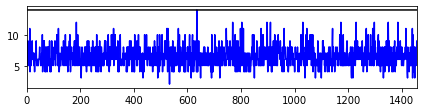

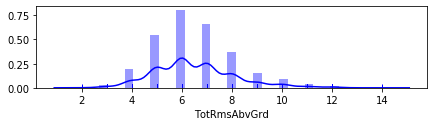

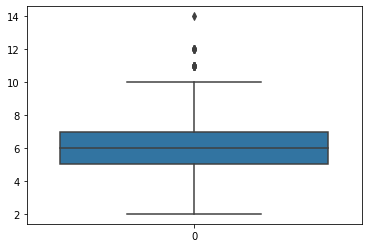

TotRmsAbvGrd has 0 NaNs.
Skewness :  0.6763408364355531
Kurtosis :  0.8807615657189474
Number of anomaly scores over threshold(0.1%) : 1 / 1460
Border line :  14.0
----------------------------------------------------------------------------------------------------


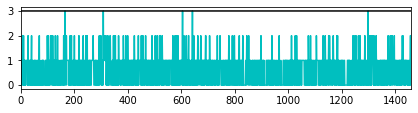

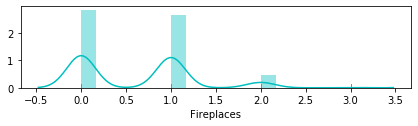

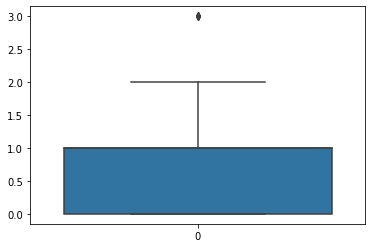

Fireplaces has 0 NaNs.
Skewness :  0.6495651830548841
Kurtosis :  -0.21723720752814657
Number of anomaly scores over threshold(0.1%) : 5 / 1460
Border line :  3.0
----------------------------------------------------------------------------------------------------


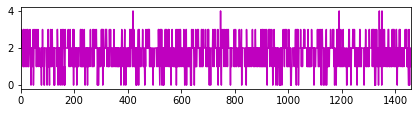

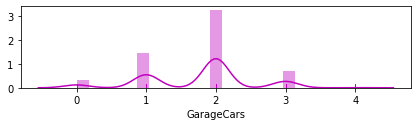

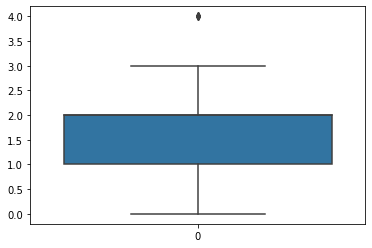

GarageCars has 0 NaNs.
Skewness :  -0.3425489297486655
Kurtosis :  0.22099776396532844
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


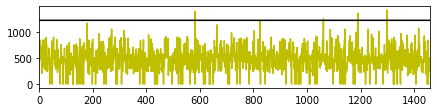

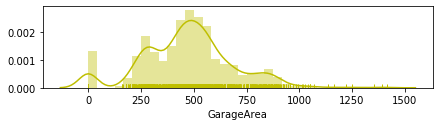

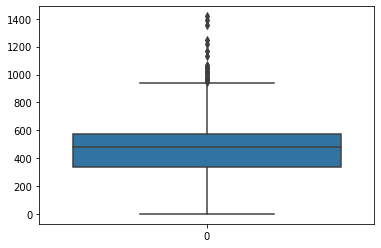

GarageArea has 0 NaNs.
Skewness :  0.17998090674623907
Kurtosis :  0.9170672022708684
Number of anomaly scores over threshold(0.1%) : 5 / 1460
Border line :  1220.0
----------------------------------------------------------------------------------------------------


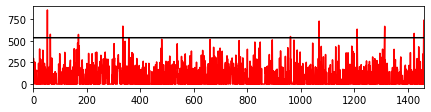

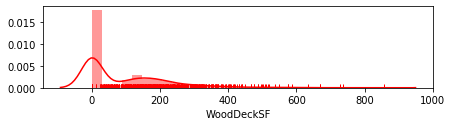

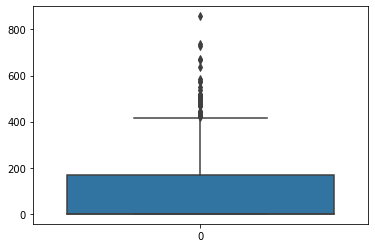

WoodDeckSF has 0 NaNs.
Skewness :  1.5413757571931312
Kurtosis :  2.992950924703908
Number of anomaly scores over threshold(0.1%) : 11 / 1460
Border line :  536.0
----------------------------------------------------------------------------------------------------


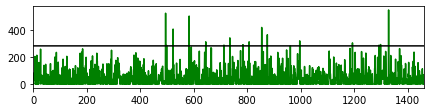

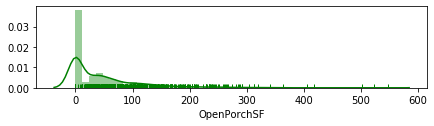

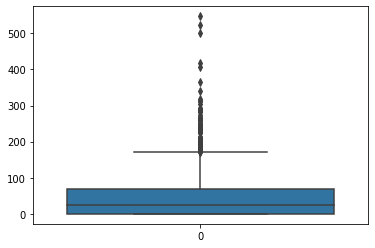

OpenPorchSF has 0 NaNs.
Skewness :  2.3643417403694404
Kurtosis :  8.490335805910506
Number of anomaly scores over threshold(0.1%) : 17 / 1460
Border line :  282.0
----------------------------------------------------------------------------------------------------


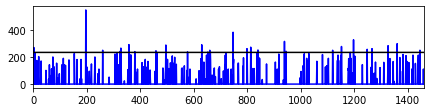

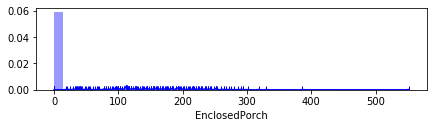

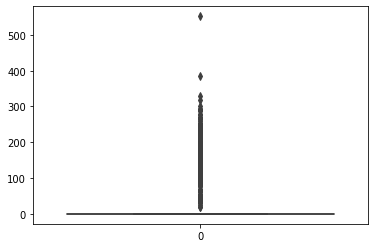

EnclosedPorch has 0 NaNs.
Skewness :  3.08987190371177
Kurtosis :  10.430765944030428
Number of anomaly scores over threshold(0.1%) : 30 / 1460
Border line :  236.0
----------------------------------------------------------------------------------------------------


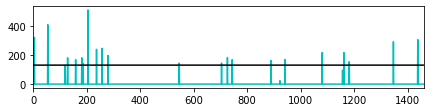

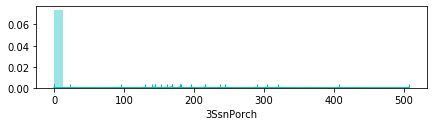

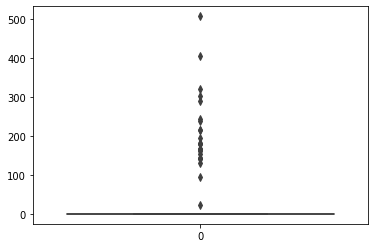

3SsnPorch has 0 NaNs.
Skewness :  10.304342032693112
Kurtosis :  123.66237944970538
Number of anomaly scores over threshold(0.1%) : 22 / 1460
Border line :  130.0
----------------------------------------------------------------------------------------------------


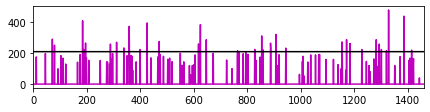

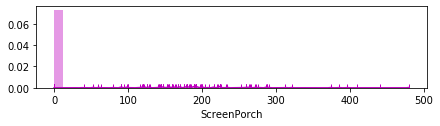

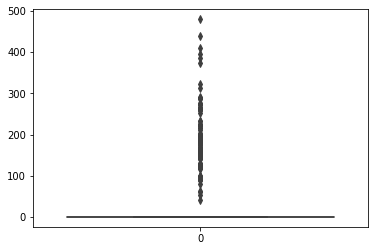

ScreenPorch has 0 NaNs.
Skewness :  4.122213743143115
Kurtosis :  18.43906784486968
Number of anomaly scores over threshold(0.1%) : 35 / 1460
Border line :  210.0
----------------------------------------------------------------------------------------------------


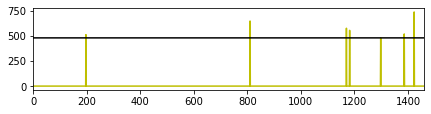

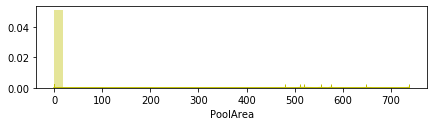

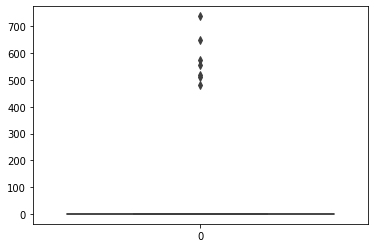

PoolArea has 0 NaNs.
Skewness :  14.828373640750588
Kurtosis :  223.2684989181717
Number of anomaly scores over threshold(0.1%) : 7 / 1460
Border line :  480.0
----------------------------------------------------------------------------------------------------


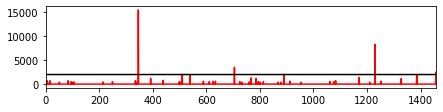

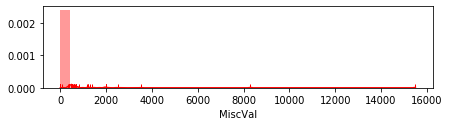

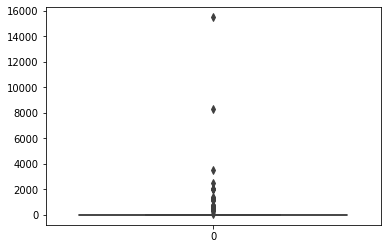

MiscVal has 0 NaNs.
Skewness :  24.476794188821916
Kurtosis :  701.0033422801193
Number of anomaly scores over threshold(0.1%) : 8 / 1460
Border line :  2000.0
----------------------------------------------------------------------------------------------------


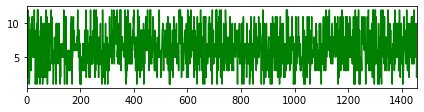

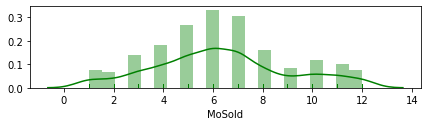

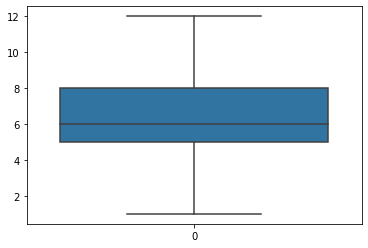

MoSold has 0 NaNs.
Skewness :  0.21205298505146022
Kurtosis :  -0.40410934153702316
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


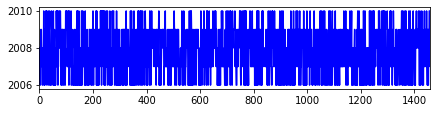

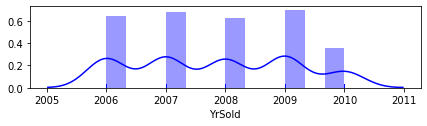

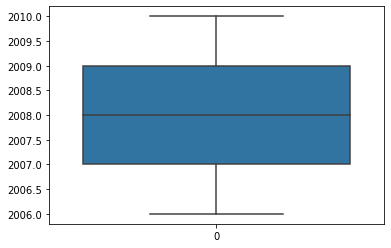

YrSold has 0 NaNs.
Skewness :  0.09626851386568028
Kurtosis :  -1.1906005711948109
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


In [77]:
# numeric_int
desc(numerics_int, data_train)

#### Numeric Float

In [12]:
numerics_float = [col for col in types.drop(['Id','SalePrice']).index 
                               if types[col]=='float64']
print('numeric_float is ...')
print(numerics_float)

numeric_float is ...
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


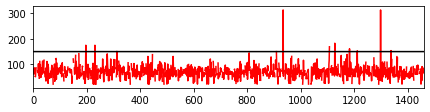

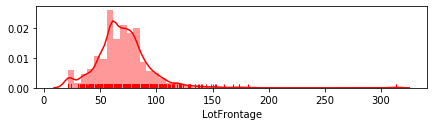

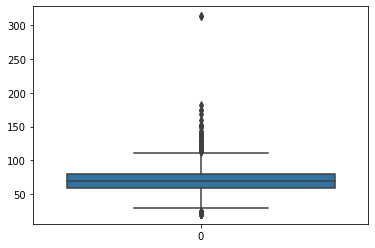

LotFrontage has 259 NaNs.
Skewness :  2.163569142324884
Kurtosis :  17.452867259818404
Number of anomaly scores over threshold(0.1%) : 11 / 1460
Border line :  149.0
----------------------------------------------------------------------------------------------------


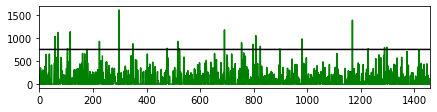

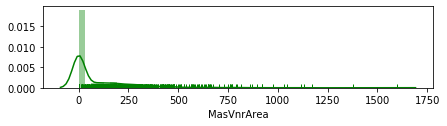

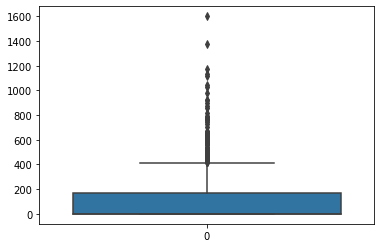

MasVnrArea has 8 NaNs.
Skewness :  2.669084210182863
Kurtosis :  10.08241731736711
Number of anomaly scores over threshold(0.1%) : 22 / 1460
Border line :  748.0
----------------------------------------------------------------------------------------------------


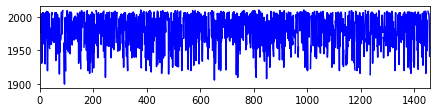

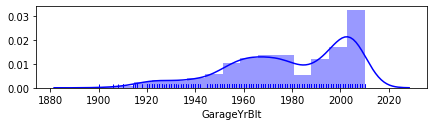

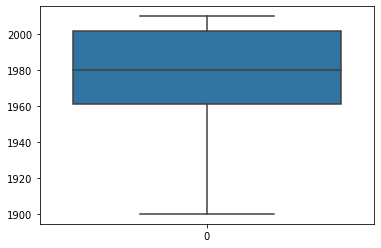

GarageYrBlt has 81 NaNs.
Skewness :  -0.6494146238714679
Kurtosis :  -0.4183409979729644
Number of anomaly scores over threshold(0.1%) : 0 / 1460
----------------------------------------------------------------------------------------------------


In [79]:
# numeric_float
desc(numerics_float, data_train)

# Preprocess

## Split data

In [13]:
_data_train = copy.deepcopy(data_train)
_x_test = copy.deepcopy(x_test)

In [14]:
x_train = _data_train.drop(['Id', 'SalePrice'], axis=1)
y_train = _data_train.SalePrice
id_test = _x_test.Id
x_test = _x_test.drop(['Id'], axis=1)

## Fix scale

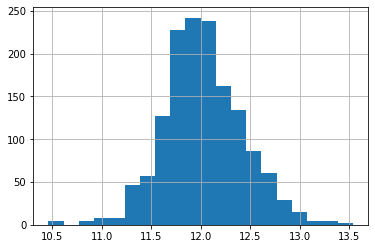

In [15]:
y_train_fixed = np.log1p(y_train)
y_train_fixed.hist(bins=20)

In this case, use y_train_fix as lognormal distribution.

## Cleaning

### Fill NaN

In [16]:
def  detect_nan(data):
    cols_isnan = []
    cols_isnan_set = []
    for i, isnan in enumerate(data.isnull().any()):
        if isnan is True:
            cols_isnan.append(data.columns[i])
            cols_isnan_set.append((data.columns[i], data.dtypes[i]))
    return cols_isnan, cols_isnan_set

In [17]:
train_cols_isnan, train_cols_isnan_set = detect_nan(x_train)
test_cols_isnan, test_cols_isnan_set = detect_nan(x_test)

In [276]:
train_cols_isnan_set

[('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinType2', dtype('O')),
 ('Electrical', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O'))]

In [277]:
test_cols_isnan_set

[('MSZoning', dtype('O')),
 ('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('Utilities', dtype('O')),
 ('Exterior1st', dtype('O')),
 ('Exterior2nd', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinSF1', dtype('float64')),
 ('BsmtFinType2', dtype('O')),
 ('BsmtFinSF2', dtype('float64')),
 ('BsmtUnfSF', dtype('float64')),
 ('TotalBsmtSF', dtype('float64')),
 ('BsmtFullBath', dtype('float64')),
 ('BsmtHalfBath', dtype('float64')),
 ('KitchenQual', dtype('O')),
 ('Functional', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageCars', dtype('float64')),
 ('GarageArea', dtype('float64')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O')),
 ('SaleT

In [20]:
cols_isnan = train_cols_isnan+test_cols_isnan
cols_isnan_set = train_cols_isnan_set+test_cols_isnan_set
types = [column[1] for column in cols_isnan_set]
uniques = set(types)
uniques

{dtype('float64'), dtype('O')}

In [21]:
def filled(data, cols):
    data_filled = copy.deepcopy(data)
    new_cols = [column+'_filled' for column in cols]
    for i, new_column in enumerate(new_cols):
        data_filled[new_column] = 0
        data_filled.loc[data_filled[cols[i]]!=data_filled[cols[i]], new_column] = 1
    data_filled['IsNaN'] = 0
    for index in range(len(data_filled)):
        if data_filled.iloc[index].isnull().any():
            data_filled['IsNaN'] = 1
    
    for column in cols:
        if data_filled[column].dtype=='object': 
            data_filled[column] = data_filled[column].fillna('NotAvailable')
        if data_filled[column].dtype=='float64':
            concat = pd.concat([x_train[column], x_test[column]])
            median = concat.median()
#             mean = concat.mean()
            data_filled[column] = data_filled[column].fillna(median) 
#             data_filled[column] = data_filled[column].fillna(mean)
    return data_filled

In [22]:
x_train_filled = filled(x_train, cols_isnan)
x_test_filled = filled(x_test, cols_isnan)
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,MSZoning_filled,Utilities_filled,Exterior1st_filled,Exterior2nd_filled,BsmtFinSF1_filled,BsmtFinSF2_filled,BsmtUnfSF_filled,TotalBsmtSF_filled,BsmtFullBath_filled,BsmtHalfBath_filled,KitchenQual_filled,Functional_filled,GarageCars_filled,GarageArea_filled,SaleType_filled,IsNaN
0,60,RL,65.0,8450,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,20,RL,80.0,9600,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,5,2007,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,60,RL,68.0,11250,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,9,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,70,RL,60.0,9550,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2006,WD,Abnorml,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,60,RL,84.0,14260,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,12,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Encord categorical to numeric

In [23]:
cols_cat = [column for column in x_train_filled.columns \
                     if x_train_filled[column].dtype=='object']

In [24]:
encoders = {}
for column in cols_cat:
    encoders[column] = LabelEncoder()
    val = x_train_filled[column].tolist()
    val.extend(x_test_filled[column].tolist())
    encoders[column].fit(val)
    x_train_filled[column] = encoders[column].transform(x_train_filled[column])+1
    x_test_filled[column] = encoders[column].transform(x_test_filled[column])+1

In [25]:
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,MSZoning_filled,Utilities_filled,Exterior1st_filled,Exterior2nd_filled,BsmtFinSF1_filled,BsmtFinSF2_filled,BsmtUnfSF_filled,TotalBsmtSF_filled,BsmtFullBath_filled,BsmtHalfBath_filled,KitchenQual_filled,Functional_filled,GarageCars_filled,GarageArea_filled,SaleType_filled,IsNaN
0,60,5,65.0,8450,2,2,4,4,1,5,1,6,3,3,1,6,7,5,2003,2003,2,2,14,15,2,196.0,3,5,3,3,5,4,3,706,7,0,150,856,2,1,2,6,856,854,0,...,0,0,4,5,2,0,2,2008,10,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,20,5,80.0,9600,2,2,4,4,1,3,1,25,2,3,1,3,6,8,1976,1976,2,2,9,9,3,0.0,4,5,2,3,5,2,1,978,7,0,284,1262,2,1,2,6,1262,0,0,...,0,0,4,5,2,0,5,2007,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,60,5,68.0,11250,2,2,1,4,1,5,1,6,3,3,1,6,7,5,2001,2002,2,2,14,15,2,162.0,3,5,3,3,5,3,3,486,7,0,434,920,2,1,2,6,920,866,0,...,0,0,4,5,2,0,9,2008,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,70,5,60.0,9550,2,2,1,4,1,1,1,7,3,3,1,6,7,5,1915,1970,2,2,15,17,3,0.0,4,5,1,5,2,4,1,216,7,0,540,756,2,3,2,6,961,756,0,...,0,0,4,5,2,0,2,2006,10,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,60,5,84.0,14260,2,2,1,4,1,3,1,16,3,3,1,6,8,5,2000,2000,2,2,14,15,2,350.0,3,5,3,3,5,1,3,655,7,0,490,1145,2,1,2,6,1145,1053,0,...,0,0,4,5,2,0,12,2008,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Feature Engineering

### ReAnalysis

In [198]:
df_train = copy.deepcopy(x_train_filled)
# df_train['SalePrice'] = y_train_fix
df_test = copy.deepcopy(x_test_filled)

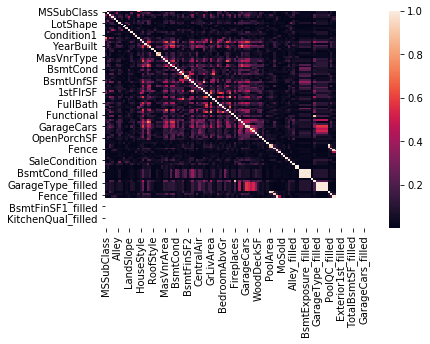

In [199]:
corr = df_train.corr(method='pearson').abs()
sns.heatmap(corr)

### Filter Method

#### Reject variance 0

In [201]:
sel  = VarianceThreshold(threshold=0)
sel.fit(df_train.dropna())
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

---
Reject features which variance is 0 (i.e. same value) in train data.

In [202]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

#### Reject variance 0.1

In [203]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(df_train.dropna())
sel.get_support()

array([ True,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False])

In [206]:
[col for i,col in enumerate(df_train.columns) if not sel.get_support()[i]]

26

---
Reject features which variance is 0.1 (i.e. about 99% is same value) in train data.

In [53]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

#### Reject high correlation coefficient

In [33]:
# corr_matrix = df_train.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
#                                                   k=1).astype(np.bool))
# cols_to_drop = [column for column in upper.columns
#                               if any(upper[column] > 0.8)]

In [34]:
# [column for column in upper.columns if any(upper[column] > 0.8)]

['Exterior2nd',
 '1stFlrSF',
 'TotRmsAbvGrd',
 'GarageArea',
 'FireplaceQu_filled',
 'Fence_filled']

In [35]:
# df_train = df_train.drop(cols_to_drop, axis=1)
# df_test = df_test.drop(cols_to_drop, axis=1)

### Matual Information

In [36]:
mi = mutual_info_regression(df_train.fillna(df_train.median()), y_train_fixed)
mi = pd.Series(mi)
mi.index = df_train.columns

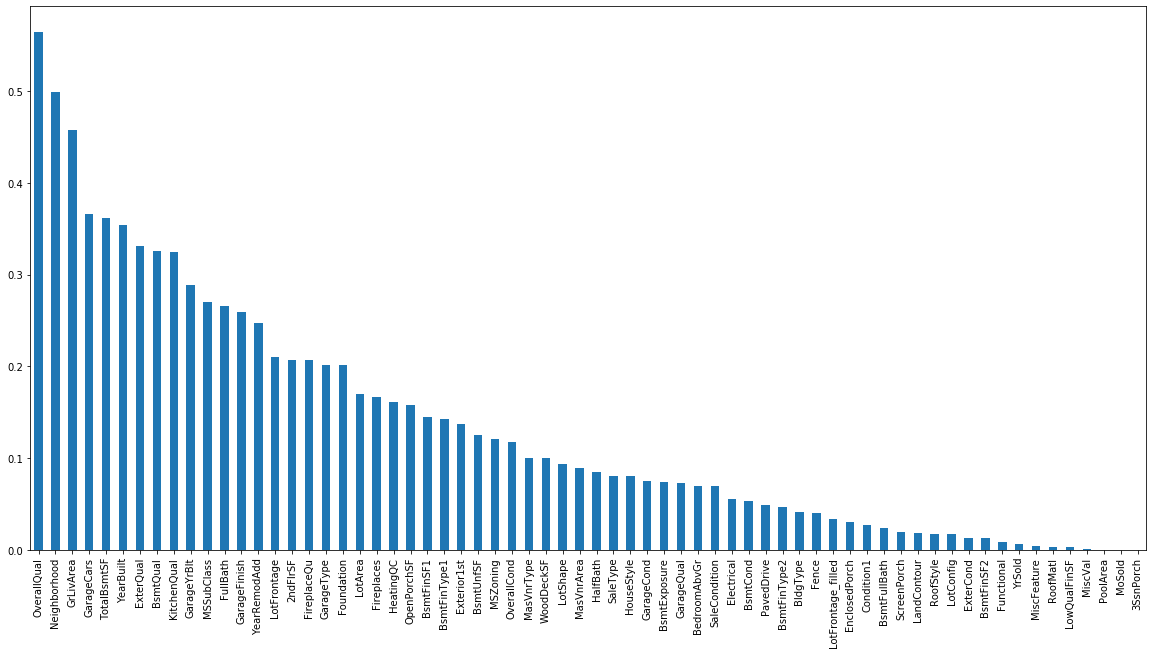

In [37]:
mi.sort_values(ascending=False).plot(kind='bar', figsize=(20,10))

### Reject Outliers 

In [593]:
types_modified = df_train.dtypes
numerics_int_modified = [col for col in types_modified.index 
                                             if types_modified[col]=='int64'
                                             and len(df_train[col].unique()) > 30]
numerics_int_kurtosised = [col for col in numerics_int_modified 
                                                if df_train[col].kurt() > 1.0]

numerics_float_modified = [col for col in types_modified.index 
                                                if types_modified[col]=='float64']
numerics_float_kurtosised = [col for col in numerics_float_modified 
                                                   if df_train[col].kurt() > 1.0]
col_quantity = numerics_int_modified + numerics_float_modified

In [46]:
types_modified

MSSubClass              int64
MSZoning                int64
LotFrontage           float64
LotArea                 int64
LotShape                int64
                       ...   
MoSold                  int64
YrSold                  int64
SaleType                int64
SaleCondition           int64
LotFrontage_filled      int64
Length: 66, dtype: object

#### Numeric Int

In [47]:
print(numerics_int_kurtosised)

['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


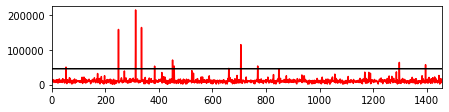

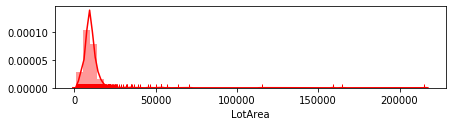

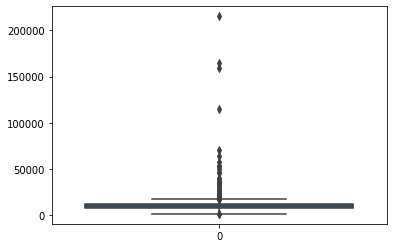

LotArea has 0 NaNs.
Skewness :  12.207687851233496
Kurtosis :  203.24327101886033
Number of anomaly scores over threshold(0.1%) : 13 / 1460
Border line :  45600.0
----------------------------------------------------------------------------------------------------


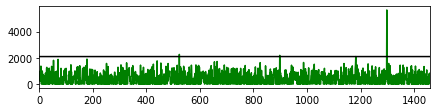

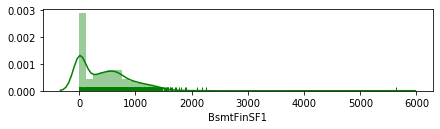

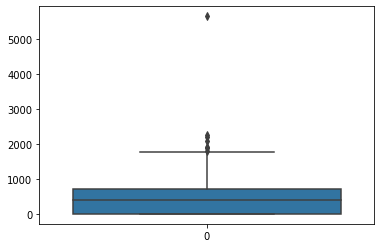

BsmtFinSF1 has 0 NaNs.
Skewness :  1.685503071910789
Kurtosis :  11.118236291964712
Number of anomaly scores over threshold(0.1%) : 4 / 1460
Border line :  2096.0
----------------------------------------------------------------------------------------------------


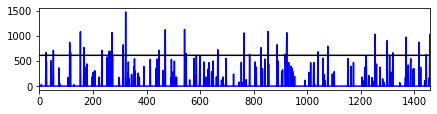

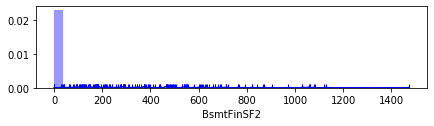

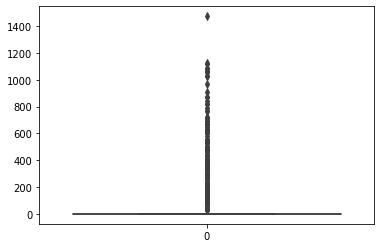

BsmtFinSF2 has 0 NaNs.
Skewness :  4.255261108933303
Kurtosis :  20.11333754558646
Number of anomaly scores over threshold(0.1%) : 36 / 1460
Border line :  612.0
----------------------------------------------------------------------------------------------------


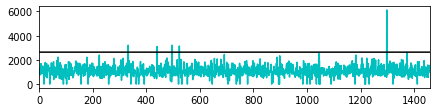

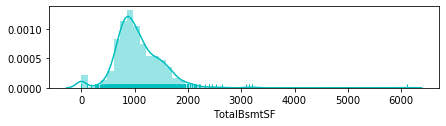

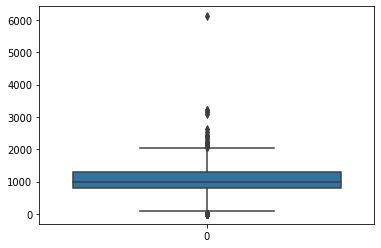

TotalBsmtSF has 0 NaNs.
Skewness :  1.5242545490627664
Kurtosis :  13.250483281984796
Number of anomaly scores over threshold(0.1%) : 6 / 1460
Border line :  2633.0
----------------------------------------------------------------------------------------------------


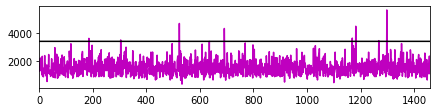

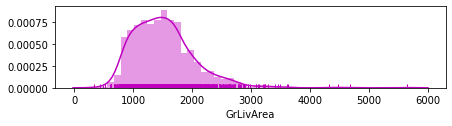

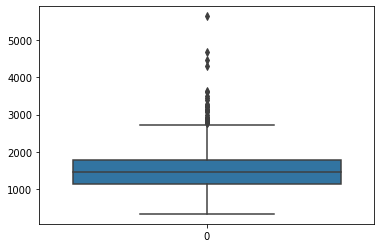

GrLivArea has 0 NaNs.
Skewness :  1.3665603560164552
Kurtosis :  4.895120580693174
Number of anomaly scores over threshold(0.1%) : 9 / 1460
Border line :  3395.0
----------------------------------------------------------------------------------------------------


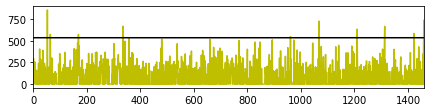

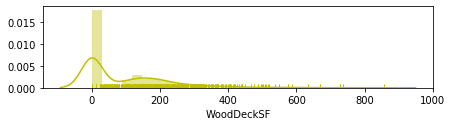

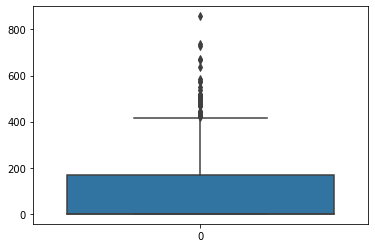

WoodDeckSF has 0 NaNs.
Skewness :  1.5413757571931312
Kurtosis :  2.992950924703908
Number of anomaly scores over threshold(0.1%) : 11 / 1460
Border line :  536.0
----------------------------------------------------------------------------------------------------


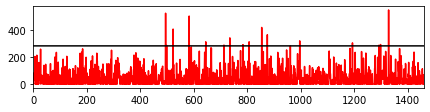

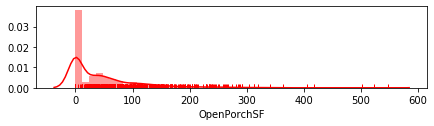

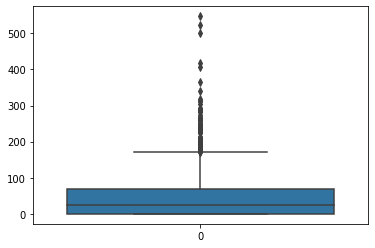

OpenPorchSF has 0 NaNs.
Skewness :  2.3643417403694404
Kurtosis :  8.490335805910506
Number of anomaly scores over threshold(0.1%) : 17 / 1460
Border line :  282.0
----------------------------------------------------------------------------------------------------


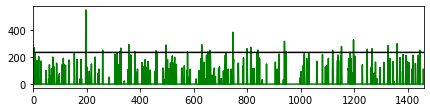

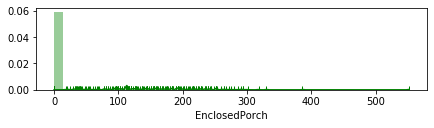

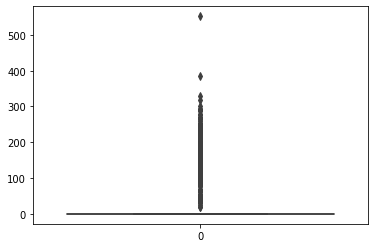

EnclosedPorch has 0 NaNs.
Skewness :  3.08987190371177
Kurtosis :  10.430765944030428
Number of anomaly scores over threshold(0.1%) : 30 / 1460
Border line :  236.0
----------------------------------------------------------------------------------------------------


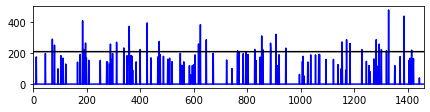

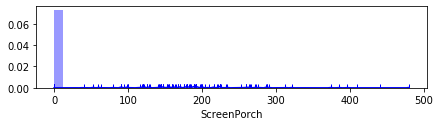

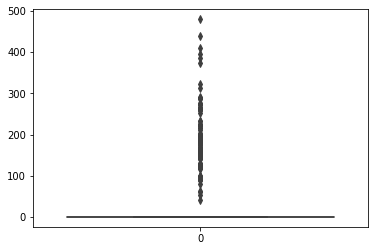

ScreenPorch has 0 NaNs.
Skewness :  4.122213743143115
Kurtosis :  18.43906784486968
Number of anomaly scores over threshold(0.1%) : 35 / 1460
Border line :  210.0
----------------------------------------------------------------------------------------------------


In [48]:
desc(numerics_int_kurtosised, df_train)

#### Numeric Float

In [49]:
print(numerics_float_kurtosised)

['LotFrontage', 'MasVnrArea']


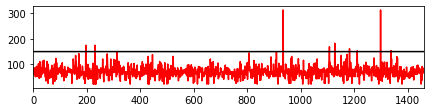

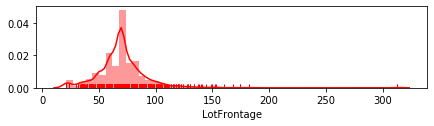

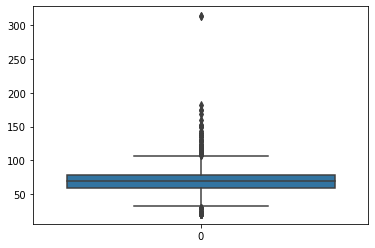

LotFrontage has 0 NaNs.
Skewness :  2.402352471321692
Kurtosis :  21.897416374398073
Number of anomaly scores over threshold(0.1%) : 11 / 1460
Border line :  149.0
----------------------------------------------------------------------------------------------------


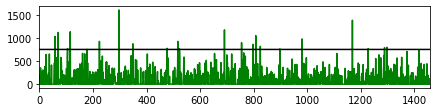

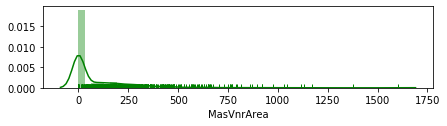

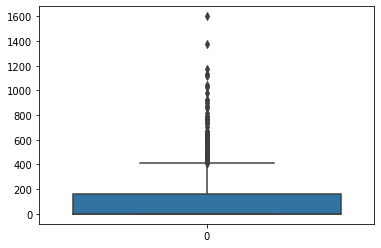

MasVnrArea has 0 NaNs.
Skewness :  2.676545581771927
Kurtosis :  10.15479013022427
Number of anomaly scores over threshold(0.1%) : 22 / 1460
Border line :  748.0
----------------------------------------------------------------------------------------------------


In [50]:
desc(numerics_float_kurtosised, df_train)

#### Drop outliers from data

In [140]:
def reject_outliers(columns, df, y, significance):
    _df = df.copy()
    _y = y.copy()
    for col in columns:
        outliers = count_byChi2(_df[col], significance)
        for i in outliers:
            if i in _df[col].index.to_list():
                _df = _df.drop(i, axis=0)
                _y = _y.drop(i, axis=0)
    return _df, _y

In [104]:
col_fix_int = [
#                         'LotArea', 
#                         'BsmtFinSF1',
#                         'BsmtFinSF2', 
#                         'TotalBsmtSF',
#                         'GrLivArea', 
#                         'WoodDeckSF',
#                         'OpenPorchSF',
#                         'EnclosedPorch', 
#                         'ScreenPorch'
                      ]
col_fix_float = [
#                             'LotFrontage',
#                             'MasVnrArea'
                         ]

In [105]:
col_fix_num = col_fix_int+col_fix_float
df_train_droped, y_train_droped = reject_outliers(  
                                                    col_fix_num,
                                                    df_train,
                                                    y_train_fixed,
                                                    0.001)

In [106]:
len(y_train_fixed), len(y_train_droped)

(1460, 1460)

In [107]:
desc(col_fix_num, df_train_droped, 0.001)

## Modularize

### Split

In [254]:
def split(df_base_train, df_base_test):
    _data_train = copy.deepcopy(df_base_train)
    _x_test = copy.deepcopy(df_base_test)
    _x_train = _data_train.drop(['Id', 'SalePrice'], axis=1)
    _y_train = _data_train.SalePrice
    id_test = _x_test.Id
    _x_test = _x_test.drop(['Id'], axis=1)
    return _x_train, _y_train, _x_test

### Transformation

In [608]:
def pick_quantity(_df_train):
    types_modified = _df_train.dtypes
    numerics_int_modified = [col for col in types_modified.index 
                                                 if types_modified[col]=='int64'
                                                 and len(_df_train[col].unique()) > 30
                                                 and col not in ('Id', 'SalePrice')]
    numerics_float_modified = [col for col in types_modified.index 
                                                     if types_modified[col]=='float64'
                                                     and col not in ('Id', 'SalePrice')]
    col_quantity = numerics_int_modified + numerics_float_modified
    return col_quantity

In [255]:
def log(df_base_y):
    _y_train_fixed = np.log1p(df_base_y)
    return _y_train_fixed

In [749]:
def boxcox(df, lam=0.15):
    _df = df.copy()
    col_skew = skews(_df, pick_quantity(_df)).index
    lam = 0.15
    for col in col_skew:
        _df[col] = boxcox1p(_df[col], lam)
    return _df

In [750]:
def boxcox(df1, df2, lam=0.15):
    _df1 = uni_boxcox(df1)
    _df2 = uni_boxcox(df2)
    return _df1, _df2

### Clean

In [394]:
def pre_clean(data, method):
    train_cols_isnan, train_cols_isnan_set = detect_nan(x_train)
    test_cols_isnan, test_cols_isnan_set = detect_nan(x_test)
    cols_isnan = train_cols_isnan+test_cols_isnan
    cols = cols_isnan
    data_filled = copy.deepcopy(data)
    new_cols = [column+'_filled' for column in cols]
    for i, new_column in enumerate(new_cols):
        data_filled[new_column] = 0
        data_filled.loc[data_filled[cols[i]]!=data_filled[cols[i]], new_column] = 1
    data_filled['IsNaN'] = 0
    for index in range(len(data_filled)):
        if data_filled.iloc[index].isnull().any():
            data_filled['IsNaN'] = 1
    
    for column in cols:
        if data_filled[column].dtype=='object': 
            data_filled[column] = data_filled[column].fillna('NotAvailable')
        if data_filled[column].dtype=='float64':
            concat = pd.concat([x_train[column], x_test[column]])
            if method is 'median':
                median = concat.median()
                data_filled[column] = data_filled[column].fillna(median)
            elif method is 'mean':
                mean = concat.mean()
                data_filled[column] = data_filled[column].fillna(mean)
            else:
                pass
    return data_filled, len(new_cols)

In [397]:
def clean(df1, df2, method):
    new_cols = []
    df1, lnc = pre_clean(df1, method)
    df2, lnc = pre_clean(df2, method)
    print('Added new columns : ', lnc, '\n')
    if method not in ('median', 'mean'):
        print('NaN is not filled. NaN is used still NaN.\n')
    return df1, df2

### Encode

In [791]:
def encode(df1, df2):
#     cols_cat = [column for column in df1.columns
#                         if df1[column].dtype=='object']
#     encoders = {}
#     for column in cols_cat:
#         encoders[column] = LabelEncoder()
#         val = df1[column].tolist()
#         val.extend(df2[column].tolist())
#         encoders[column].fit(val)
#         df1[column] = encoders[column].transform(df1[column])+1
#         df2[column] = encoders[column].transform(df2[column])+1
#     return df1, df2
    all_data = pd.concat((df1, df2)).reset_index(drop=True)
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)
    all_data = pd.get_dummies(all_data)
    _train = all_data[:len(df1)]
    _test = all_data[len(df1):]
    return _train, _test

### Reject low variances

In [424]:
def rejectLowVar(_df_train, _df_test, threshold):
    sel = VarianceThreshold(threshold)
    sel.fit(_df_train.dropna())
    sel.get_support()
    drops = [col for i,col in enumerate(_df_train.columns) if not sel.get_support()[i]]
    __df_train = _df_train.loc[:, sel.get_support()]
    __df_test = _df_test.loc[:, sel.get_support()]
    print('Droped by Var : ', drops, '\n')
    return __df_train, __df_test

### Reject high correlation coefficient

In [409]:
def rejectHighCorr(_df_train, _df_test, threshold):
    corr_matrix = _df_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                                    k=1).astype(np.bool))
    cols_to_drop = [column for column in upper.columns
                                if any(upper[column] > threshold)]
    __df_train = _df_train.drop(cols_to_drop, axis=1)
    __df_test = _df_test.drop(cols_to_drop, axis=1)
    print('Droped columns by Corr : ', cols_to_drop, '\n')
    return __df_train, __df_test

### Reject outliers

In [639]:
col_highKur_int = [
#                         'LotArea', 
#                         'BsmtFinSF1',
#                         'BsmtFinSF2', 
#                         'TotalBsmtSF',
#                         'GrLivArea', 
#                         'WoodDeckSF',
#                         'OpenPorchSF',
#                         'EnclosedPorch', 
#                         'ScreenPorch'
                          ]
col_highKur_float = [
#                             'LotFrontage',
#                             'MasVnrArea'
                             ]
col_highKur_num = col_highKur_int+col_highKur_float

In [578]:
def rejectOutliers(columns, df, y, significance):
    _df = df.copy()
    _y = y.copy()
    for col in columns:
        outliers = count_byChi2(_df[col], significance)
        for i in outliers:
            if i in _df[col].index.to_list():
                _df = _df.drop(i, axis=0)
                _y = _y.drop(i, axis=0)
    print('Droped data by Outliers from : ', columns,'\n')
    return _df, _y

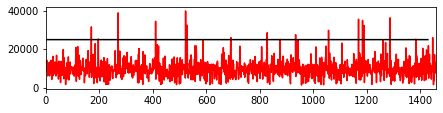

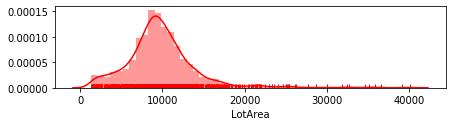

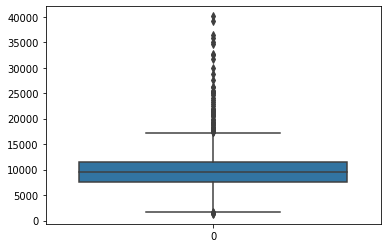

LotArea has 0 NaNs.
Skewness :  1.8653914120900632
Kurtosis :  8.371161144924411
Number of anomaly scores over threshold(0.1%) : 18 / 1429
Border line :  25095.0
----------------------------------------------------------------------------------------------------


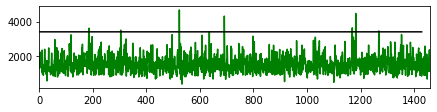

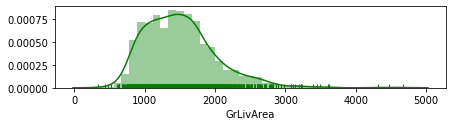

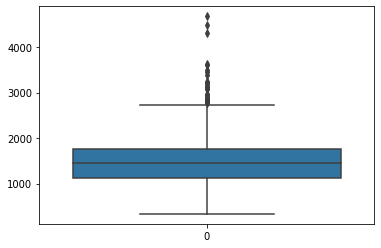

GrLivArea has 0 NaNs.
Skewness :  1.1330827899592628
Kurtosis :  2.8310782546371565
Number of anomaly scores over threshold(0.1%) : 8 / 1429
Border line :  3395.0
----------------------------------------------------------------------------------------------------


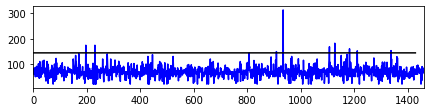

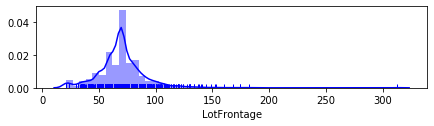

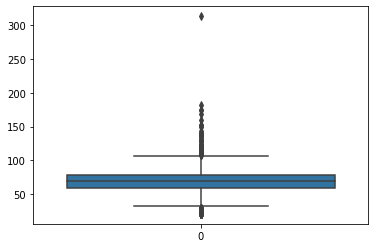

LotFrontage has 0 NaNs.
Skewness :  1.7379435794372624
Kurtosis :  14.992717228978371
Number of anomaly scores over threshold(0.1%) : 10 / 1429
Border line :  144.0
----------------------------------------------------------------------------------------------------


In [582]:
desc(col_highKur_num, df_train, 0.001)

### Special

In [761]:
def special(df, y):
    drop = data_train[(data_train['GrLivArea']>4000) & (data_train['SalePrice']<300000)].index
    _df = df.drop(drop)
    _y = y.drop(drop)
    return _df, _y

## Finally

In [787]:
data_train = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/train.csv')
x_test = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/test.csv')

In [833]:
df_train, df_y, df_test = split(_data_train, x_test)
df_y = log(df_y)
df_train, df_y = special(df_train, df_y)
# df_train, df_test = boxcox(df_train, df_test)
df_train, df_test = clean(df_train, df_test, 'mean')
df_train, df_test = encode(df_train, df_test)
df_train, df_test = rejectLowVar(df_train, df_test, 0.0)
df_train, df_test = rejectHighCorr(df_train, df_test, 0.8)
df_train, df_y = rejectOutliers(col_highKur_num, df_train, df_y, 0.01)
print('Before preprocess : ', data_train.shape)
print('After preprocess : ', df_train.shape)

df_train, df_val, df_y, df_y_val = train_test_split(df_train, df_y, test_size=0.2, shuffle=True)

Added new columns :  52 

Droped by Var :  ['MSZoning_filled', 'Utilities_filled', 'Exterior1st_filled', 'Exterior2nd_filled', 'BsmtFinSF1_filled', 'BsmtFinSF2_filled', 'BsmtUnfSF_filled', 'TotalBsmtSF_filled', 'BsmtFullBath_filled', 'BsmtHalfBath_filled', 'KitchenQual_filled', 'Functional_filled', 'GarageCars_filled', 'GarageArea_filled', 'SaleType_filled', 'IsNaN', 'MSSubClass_150', 'MSZoning_NotAvailable', 'Utilities_NotAvailable', 'Exterior1st_NotAvailable', 'Exterior2nd_NotAvailable', 'KitchenQual_NotAvailable', 'Functional_NotAvailable', 'SaleType_NotAvailable'] 

Droped columns by Corr :  ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'MasVnrArea_filled', 'BsmtCond_filled', 'BsmtExposure_filled', 'BsmtFinType1_filled', 'BsmtFinType2_filled', 'FireplaceQu_filled', 'GarageYrBlt_filled', 'GarageFinish_filled', 'GarageQual_filled', 'GarageCond_filled', 'PoolQC_filled', 'MSZoning_RM', 'Street_Pave', 'Alley_NotAvailable', 'LotShape_Reg', 'Utilities_NoSeWa', 'LandSlope_Mod', 'Neighborhood_

# Results

In [533]:
pd.set_option("display.max_colwidth", 2000)
results = pd.DataFrame(columns=['cv_score','test_score','n_trial','n_feature','length','logy', 'fill_NumNaN', 'Var', 'Corr', 'Sig', 'parms'])

result_normal = pd.Series([0.11797732129883243,0.12765,300,98,1460,'T','mean',0.0,1.0,0.000,
                          {'eta': 0.07468527174954286, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7943247346338808, 'colsample_bytree': 0.10040669901759372}
                          ], index=results.columns, name='Normal')
result_dropVar = pd.Series([0.11949074617401449,0.13109,300,72,1460,'T','mean',0.1,1.0,0.000,
                           {'eta': 0.1139993389234079, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.6685702562897783, 'colsample_bytree': 0.11244844993673414}
                           ], index=results.columns, name='DropVar')
result_dropCorr = pd.Series([0.11971792368667009,0.12605,300,80,1460,'T','mean',0.0,0.8,0.000,
                            {'eta': 0.686348307000918, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.5831758029321384, 'colsample_bytree': 0.2760603209685458}
                            ], index=results.columns, name='DropCorr')
result_dropOutliers = pd.Series([0.12017973486270087,0.12500,300,98,1421,'T','mean',0.0,1.0,'0.001(abdej)',
                                {'eta': 0.52648195557329, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7472422082497788, 'colsample_bytree': 0.14696248124979822}
                                ], index=results.columns, name='DropOutliers')
result_dropOutliersH = pd.Series([0.1126795528401672,0.12741,300,98,1390,'T','mean',0.0,1.0,'0.01(abdej)',
                                 {'eta': 0.03403778824495164, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.8631683110938955, 'colsample_bytree': 0.13739591981904495}
                                 ], index=results.columns, name='DropOutliersH')
result_dropOutliers3 = pd.Series([0.11981790222499122,0.12637,300,98,1429,'T','mean',0.0,1.0,'0.001(aej)',
                                 {'eta': 0.046757236965744436, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.703670734477893, 'colsample_bytree': 0.19429508413482025}
                                 ], index=results.columns, name='DropOutliers3')
result_dropOutliers8 = pd.Series([0.1199830647507603,0.13011,300,98,1373,'T','mean',0.0,1.0,'0.001(abdefgjk)',
                                 {'eta': 0.1172799599189829, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.7390395949254, 'colsample_bytree': 0.1970224088747218}
                                 ], index=results.columns, name='DropOutliers8')
result_KeepNumNAN = pd.Series([0.1199490606812944,0.13033,300,89,1460,'T','not filled',0.0,1.0,0.000,
                              {'eta': 0.02933807065412462, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8766968360775202, 'colsample_bytree': 0.23120529069702545}
                              ], index=results.columns, name='KeepNumNAN')
result_CO = pd.Series([0.11923182800114115,0.12237,300,80,1421,'T','mean',0.0,0.8,'0.001(abdej)',
                      {'eta': 0.03171459174114307, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8795326570561904, 'colsample_bytree': 0.35857238686073184}
                      ], index=results.columns, name='DropCorrOutliers')

results = results.append(result_normal).append(result_dropVar).append(result_dropCorr).append(result_dropOutliers) \
                .append(result_dropOutliers3).append(result_dropOutliersH).append(result_dropOutliers8) .append(result_KeepNumNAN) \
                .append(result_CO)
results

,cv_score,test_score,n_trial,n_feature,length,logy,fill_NumNaN,Var,Corr,Sig,parms
Normal,0.117977,0.12765,300,98,1460,T,mean,0.0,1.0,0,"{'eta': 0.07468527174954286, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7943247346338808, 'colsample_bytree': 0.10040669901759372}"
DropVar,0.119491,0.13109,300,72,1460,T,mean,0.1,1.0,0,"{'eta': 0.1139993389234079, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.6685702562897783, 'colsample_bytree': 0.11244844993673414}"
DropCorr,0.119718,0.12605,300,80,1460,T,mean,0.0,0.8,0,"{'eta': 0.686348307000918, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.5831758029321384, 'colsample_bytree': 0.2760603209685458}"
DropOutliers,0.120180,0.12500,300,98,1421,T,mean,0.0,1.0,0.001(abdej),"{'eta': 0.52648195557329, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7472422082497788, 'colsample_bytree': 0.14696248124979822}"
DropOutliers3,0.119818,0.12637,300,98,1429,T,mean,0.0,1.0,0.001(aej),"{'eta': 0.046757236965744436, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.703670734477893, 'colsample_bytree': 0.19429508413482025}"
DropOutliersH,0.112680,0.12741,300,98,1390,T,mean,0.0,1.0,0.01(abdej),"{'eta': 0.03403778824495164, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.8631683110938955, 'colsample_bytree': 0.13739591981904495}"
DropOutliers8,0.119983,0.13011,300,98,1373,T,mean,0.0,1.0,0.001(abdefgjk),"{'eta': 0.1172799599189829, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.7390395949254, 'colsample_bytree': 0.1970224088747218}"
KeepNumNAN,0.119949,0.13033,300,89,1460,T,not filled,0.0,1.0,0,"{'eta': 0.02933807065412462, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8766968360775202, 'colsample_bytree': 0.23120529069702545}"
DropCorrOutliers,0.119232,0.12237,300,80,1421,T,mean,0.0,0.8,0.001(abdej),"{'eta': 0.03171459174114307, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8795326570561904, 'colsample_bytree': 0.35857238686073184}"


# Learn

## Boruta

In [57]:
# rfr = RandomForestRegressor()
# feat_selecotr = BorutaPy(
#     rfr,
#     n_estimators='auto',
#     alpha=0.05,
#     two_step=False,
#     verbose=2,
#     perc=80,
#     max_iter=150
# )
# feat_selecotr.fit(df_train.to_numpy(), y_train_fix.to_numpy())

In [58]:
# df_train = df_train.loc[:, feat_selecotr.support_]
# df_test = df_test.loc[:, feat_selecotr.support_]

## Optuna

In [810]:
def objective(trial):
    # Booster Parameters
    eta = trial.suggest_loguniform('eta', 1e-2, 1)  # = learning rate
#     gamma = trial.suggest_uniform('gamma', 0, 1e2)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)  
    max_depth = trial.suggest_int('max_depth', 2, 6)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_loguniform('subsample', 0.5, 0.9)
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
#     alpha = trial.suggest_uniform('alpha', 0, 1e2)
#     reg_lambda = trial.suggest_uniform('reg_lambda', 0, 1e2)
    
    model =  XGBRegressor(
        objective='reg:squarederror',
        n_estimators=900,
        eta=eta,
#         gamma=gamma,
#         learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
#         alpha=alpha,
#         reg_lambda=reg_lambda
    )
    kf = KFold(5, shuffle=True).get_n_splits(X=df_train, y=df_y)
    rmse = np.sqrt(-cross_val_score(model, df_train,df_y,
                                                                scoring="neg_mean_squared_error",
                                                                cv=kf, verbose=0))
    
    return rmse.mean()

In [811]:
study = optuna.create_study()

In [812]:
study.optimize(func=objective,
                            n_trials=300, 
                            timeout=None, 
                            n_jobs=-1)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:12:24,450] Finished trial#12 resulted in value: 0.1173984354376079. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:14:30,247] Finished trial#29 resulted in value: 0.11787031293618944. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboos

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:14:59,466] Finished trial#35 resulted in value: 0.11581822642968342. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboos

[I 2019-12-14 03:16:02,397] Finished trial#47 resulted in value: 0.11564243827734855. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:16:04,236] Finished trial#48 resulted in value: 0.11455435429071811. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None an

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:17:54,843] Finished trial#61 resulted in value: 0.12267675895499061. Current best value is 0.11418441343355017 with parameters: {'eta': 0.06271130708412727, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6095542716873776, 'colsample_bytree': 0.5250687809707407}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboos

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:19:04,277] Finished trial#79 resulted in value: 0.11501278176703385. Current best value is 0.11378536504079033 with parameters: {'eta': 0.4519237962772526, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.591993111123207, 'colsample_bytree': 0.16323377877646988}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:21:57,099] Finished trial#114 resulted in value: 0.11473770673173582. Current best value is 0.11378536504079033 with parame

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:22:21,242] Finished trial#121 resulted in value: 0.1161245560540171. Current best value is 0.11378536504079033 with parameters: {'eta': 0.4519237962772526, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.591993111123207, 'colsample_bytree': 0.16323377877646988}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:22:49,571] Finished trial#126 resulted in value: 0.11579626975869753. Current best value is 0.11378536504079033 with parameters: {'eta': 0.4519237962772526, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.591993111123207, 'colsample_bytree': 0.16323377877646988}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboos

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:23:48,642] Finished trial#136 resulted in value: 0.11846499701980781. Current best value is 0.11378536504079033 with parameters: {'eta': 0.4519237962772526, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.591993111123207, 'colsample_bytree': 0.16323377877646988}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboos

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:25:11,659] Finished trial#158 resulted in value: 0.11466212459306953. Current best value is 0.11369074469685321 with parame

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:25:37,150] Finished trial#164 resulted in value: 0.11473911886293701. Current best value is 0.11369074469685321 with parameters: {'eta': 0.17511747057480007, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.5842547211368943, 'colsample_bytree': 0.15680064773150365}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:26:03,839] Finished trial#171 resulted in value: 0.11507833090781336. Current best value is 0.11369074469685321 with parameters: {'eta': 0.17511747057480007, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.5842547211368943, 'colsample_bytree': 0.15680064773150365}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:26:34,517] Finished trial#177 resulted in value: 0.11480014414698614. Current best value is 0.11369074469685321 with parameters: {'eta': 0.17511747057480007, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.5842547211368943, 'colsample_bytree': 0.15680064773150365}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:26:37,065] Finished trial#174 resulted in value: 

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:27:33,444] Finished trial#189 resulted in value: 0.11572334744432855. Current best value is 0.11369074469685321 with parameters: {'eta': 0.17511747057480007, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.5842547211368943, 'colsample_bytree': 0.15680064773150365}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:28:25,797] Finished trial#201 resulted in value: 0.11447518941402637. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:28:26,839] Finished trial#202 resulted in value: 0.11476671405267316. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.160564094170

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:28:53,192] Finished trial#207 resulted in value: 0.11495520258838769. Current best value is 0.11331313921998838 with parame

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:29:45,990] Finished trial#219 resulted in value: 0.11559947572812099. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:29:47,895] Finished trial#220 resulted in value: 

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:30:14,025] Finished trial#225 resulted in value: 0.11700868606120549. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[I 2019-12-14 03:31:05,278] Finished trial#238 resulted in value: 0.11491146186408338. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

[I 2019-12-14 03:31:56,563] Finished trial#250 resulted in value: 0.11601377411503173. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

[I 2019-12-14 03:32:52,458] Finished trial#262 resulted in value: 0.11430575786602679. Current best value is 0.11331313921998838 with parameters: {'eta': 0.26603014813532255, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5979982523977219, 'colsample_bytree': 0.16056409417055256}.
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgbo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

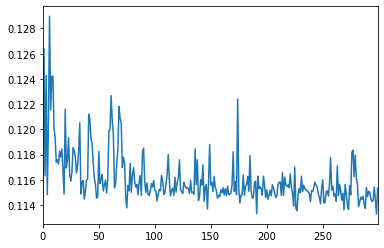

In [813]:
df_hist = study.trials_dataframe()
df_hist.value.plot()
# plt.savefig('../results/.png')

## Create Model

In [828]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=900,
)

## Fit

In [834]:
kf = KFold(5, shuffle=True).get_n_splits(X=df_val, y=df_y_val)
rmse = np.sqrt(-cross_val_score(model, df_val,df_y_val,
                                                            scoring="neg_mean_squared_error",
                                                            cv=kf, verbose=0))
model.fit(df_val, df_y_val)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=900,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [835]:
print('---RMSE---')
print('CROSS : {}'.format(rmse))
print('MEAN : {}'.format(rmse.mean()))

---RMSE---
CROSS : [0.12323431 0.18218093 0.12837304 0.14028575 0.215273  ]
MEAN : 0.1578694050408589


In [817]:
pred = np.expm1(model.predict(df_test))
print(pred[:5])

[121920.54 158298.08 194894.3  202837.1  196356.2 ]


# Submit

In [818]:
submit = pd.DataFrame({'Id':id_test, 'SalePrice':pred})
submit.to_csv('../data/submission_xgboost.csv', index=False)